In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
train_1 = pd.read_csv(r'D:\UNIVERSITA\MAGISTRALE\Secondo anno\StatMachineLearning\WebTrafficForecasting\web-traffic-time-series-forecasting\train_1.csv')
new = train_1["Page"].str.rsplit(".org_", n = 1, expand = True)
train_1['Page'] = new[0] + '.org'
train_1['Type_of_traffic'] = new[1]
new = train_1["Type_of_traffic"].str.split("_", n = 1, expand = True)
train_1['Type_of_traffic'] = new[0]
train_1['Agent'] = new[1]

In [3]:
def get_location(regex, series):
    data = pd.DataFrame([])
    for row in series:
        if re.search(regex, row):
            data = data.append(pd.DataFrame({'location': re.search(regex, row).group(1)}, index=[0]), ignore_index=True) 
        else:
            data = data.append(pd.DataFrame({'location': 'na'}, index=[0]), ignore_index=True)
    return data

In [4]:
new = get_location(r'.+_(\w{2})\.wiki', train_1['Page'])
train_1['location'] = new['location']

In [5]:
train_1_melted = pd.melt(train_1, id_vars=['Page', 'Type_of_traffic', 'Agent', 'location'], var_name='Date', value_name='count')
train_1_melted['Date'] = train_1_melted['Date'].astype('datetime64[ns]')
data = train_1_melted[['Date', 'Page', 'Type_of_traffic', 'Agent', 'count']].groupby(['Date', 'Page']).sum()

In [6]:
del train_1
del train_1_melted

In [7]:
data = data.reset_index()
data = data.set_index('Date')

In [8]:
most_frequent = data[data['Page']=='2NE1_zh.wikipedia.org']
most_frequent_series = most_frequent['count']

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
import pymc3 as pm
from theano import shared
predictors = most_frequent_series[:400].values

predictors_shared = shared(predictors)

tau = 0.001

model = pm.Model()
with model:
    
    beta = pm.Uniform('beta',lower = -1, upper = 1,  shape = 4)
    y_obs = pm.AR('y_obs', rho = beta, tau=tau, observed=predictors_shared)
    #trace = pm.sample(2000, tune=1000)
    step = pm.Metropolis()
    
    n_draws, n_chains = 3000, 3
    n_sim = n_draws*n_chains
    
    # Consider 3000 draws and 2 chains.
    trace = pm.sample(draws=n_draws, njobs=n_chains, step = step, tune = 2000)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 15000/15000 [00:09<00:00, 1580.93draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
trace_df = pm.trace_to_dataframe(trace)

In [16]:
def my_trace_plot(trace_df):
    for i in range(len(trace_df.columns)):
        fig, ax = plt.subplots(1, 2, figsize=(12,6))
        ax[0].plot(trace_df.iloc[:,i])
        ax[0].set_title(trace_df.columns[i])
        ax[1] = trace_df.iloc[:,i].plot.kde()
        ax[1].set_title('kde')
        plt.show()

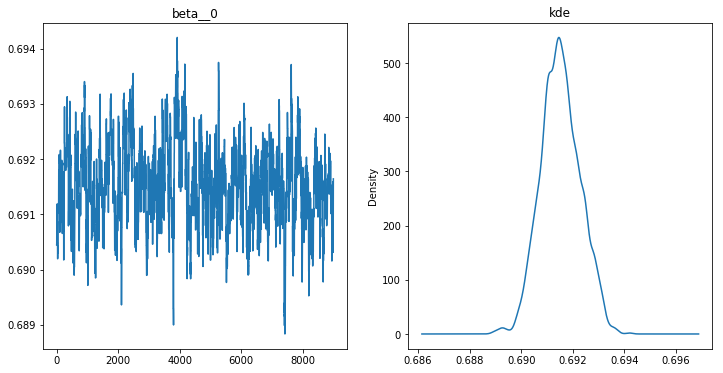

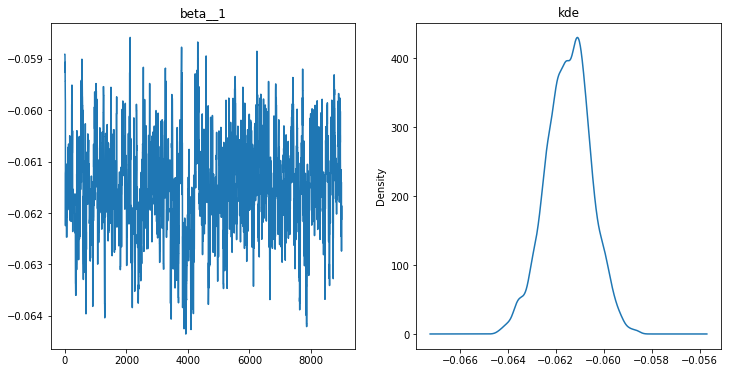

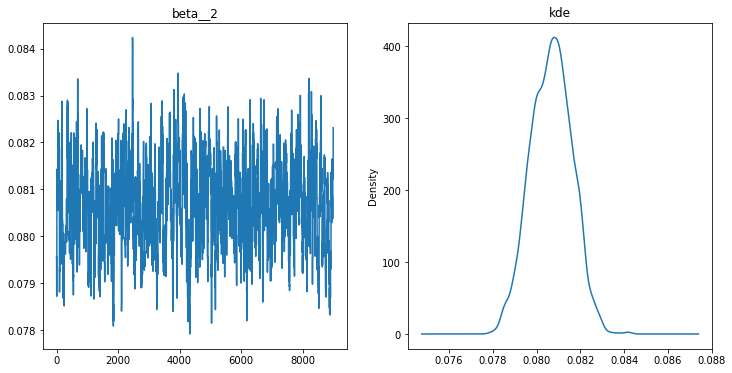

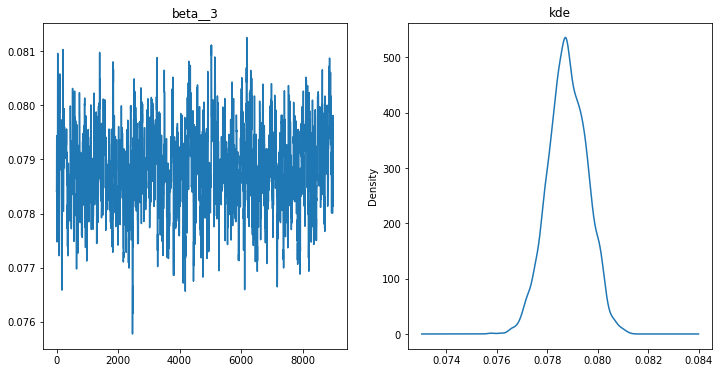

In [17]:
my_trace_plot(trace_df)

In [18]:
pm.gelman_rubin(trace)

{'beta': array([1.01307506, 1.0048899 , 0.99985889, 1.00092   ])}

In [19]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,0.691530,0.000759,0.000052,0.690185,0.693083,155.314378,1.013075
beta__1,-0.061468,0.000935,0.000050,-0.063187,-0.059461,255.023503,1.004890
beta__2,0.080678,0.000930,0.000045,0.078946,0.082506,307.680656,0.999859
beta__3,0.078809,0.000770,0.000035,0.077373,0.080323,367.894121,1.000920


In [20]:
import seaborn as sns
def corrplot(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(6, 6)) 
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = 1
    sns.heatmap(corr, mask= mask, ax= ax, annot= True)

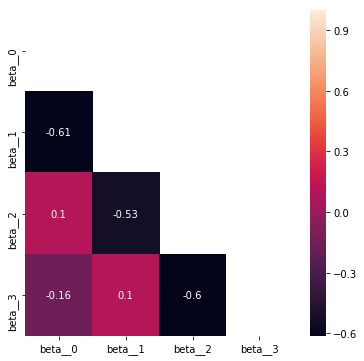

In [21]:
corrplot(trace_df)

In [23]:
model = pm.Model()
with model:
    
    beta = pm.Uniform('beta',lower = -1, upper = 1,  shape = 4)
    y_obs = pm.AR('y_obs', rho = beta, tau=tau, observed=predictors_shared)
    #trace = pm.sample(2000, tune=1000)
    step = pm.ADVI()
    
    n_draws, n_chains = 3000, 3
    n_sim = n_draws*n_chains
    
    advi_fit = pm.fit(method=pm.ADVI(), n=30000)
    
    # Consider 3000 draws and 2 chains.
    #advi_trace = pm.sample(draws=n_draws, njobs=n_chains, step = step, tune = 1000)
    
advi_trace = advi_fit.sample(10000)

Average Loss = 8.82e+05: 100%|█████████████████████████████████████████████████| 30000/30000 [00:11<00:00, 2545.07it/s]
Finished [100%]: Average Loss = 8.82e+05


In [24]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

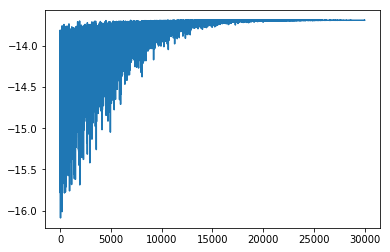

In [25]:
plt.plot(advi_elbo['n'].values, advi_elbo['log-ELBO'].values)
plt.show()

In [26]:
advi_trace_df = pm.trace_to_dataframe(advi_trace)

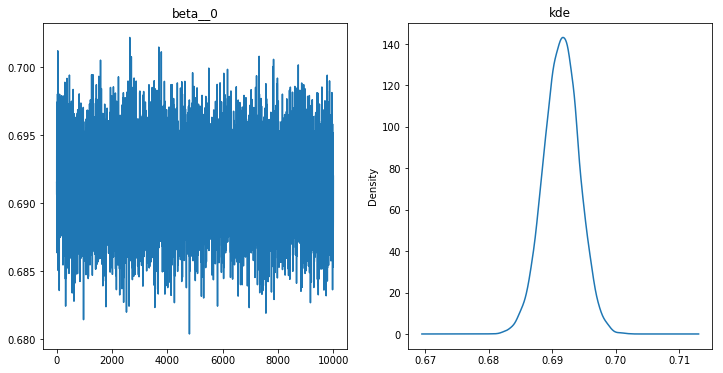

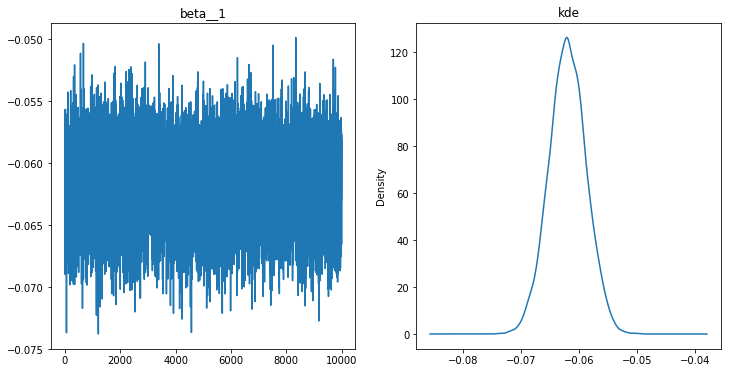

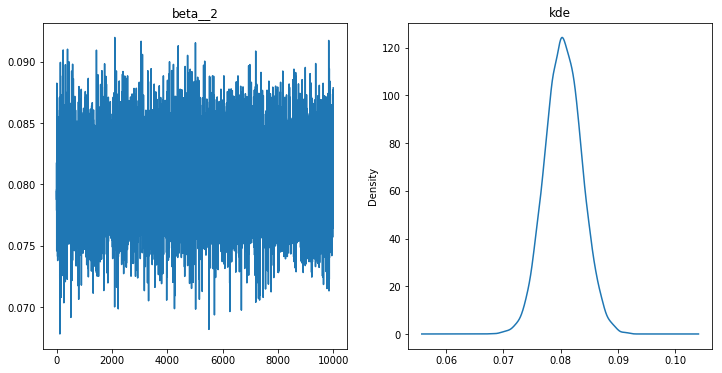

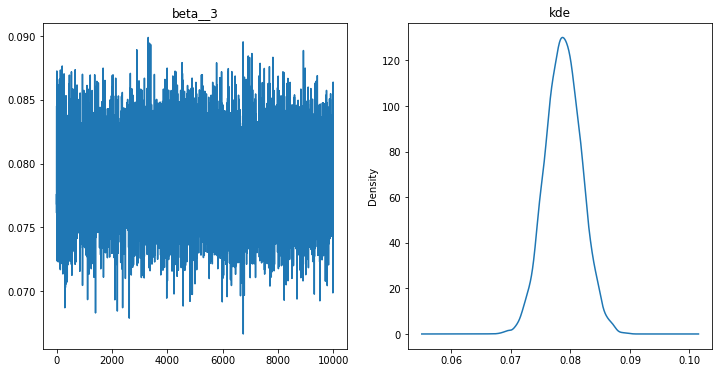

In [27]:
my_trace_plot(advi_trace_df)

In [28]:
pm.stats.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta__0,0.691443,0.002756,0.000027,0.685948,0.696763
beta__1,-0.061967,0.003180,0.000033,-0.067978,-0.055429
beta__2,0.080467,0.003186,0.000032,0.074297,0.086760
beta__3,0.078813,0.003018,0.000030,0.073277,0.085095


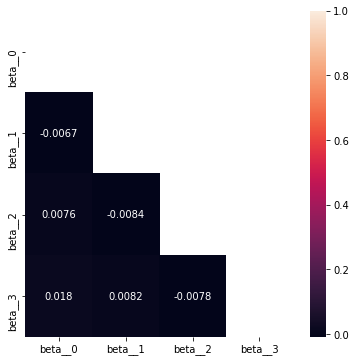

In [29]:
corrplot(advi_trace_df)

In [106]:
print(prova[prova!=most_frequent_series[:400]])

Series([], Name: 0, dtype: float64)


In [107]:
mean_absolute_percentage_error(most_frequent_series[:400], prova)

0.0

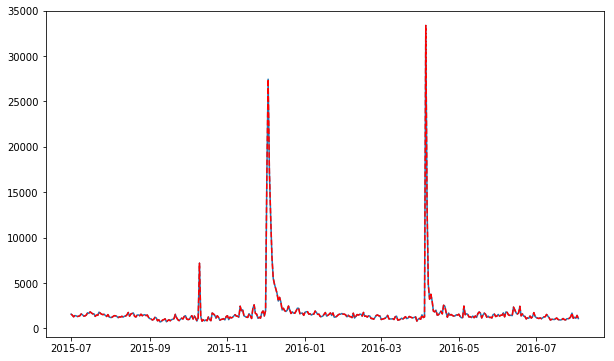

In [91]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(prova)
plt.plot(most_frequent_series[:400], 'r', linestyle = '--')
plt.show()

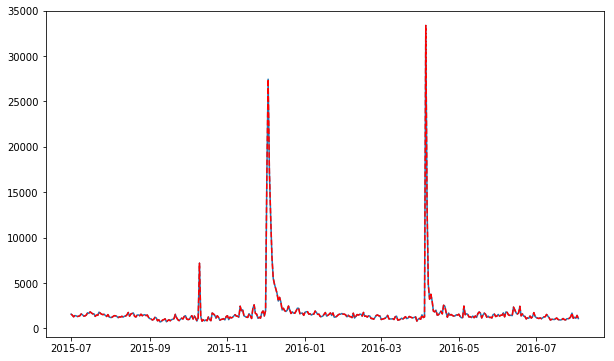

In [93]:
prova = yhat4.iloc[33]
prova.index = most_frequent_series[:400].index


%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(prova)
plt.plot(most_frequent_series[:400], 'r', linestyle = '--')
plt.show()

In [30]:
import warnings
from statsmodels.tsa.arima_model import ARIMA

model_class = ARIMA(most_frequent_series[:400], (4,0,0))
model_fit = model_class.fit(disp=0, trend='nc')

C:\Users\iacu9\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\iacu9\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\iacu9\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\iacu9\Anaconda3\lib\site-packages\scipy\signal\signa

In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  count   No. Observations:                  400
Model:                     ARMA(4, 0)   Log Likelihood               -3627.616
Method:                       css-mle   S.D. of innovations           2098.677
Date:                Fri, 12 Jul 2019   AIC                           7265.231
Time:                        17:38:46   BIC                           7285.189
Sample:                    07-01-2015   HQIC                          7273.135
                         - 08-03-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.count     0.6905      0.050     13.875      0.000       0.593       0.788
ar.L2.count    -0.0610      0.060     -1.009      0.313      -0.179       0.057
ar.L3.count     0.0803      0.060      1.330      0.184      -0.038       0.199
ar.L4.count     0.0781      0.050      1.575      0.116      -0.019       0.175
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1704           -0.0000j            1.1704           -0.0000
AR.2            0.3451           -1.9148j            1.9457           -0.2216
AR.3            0.3451           +1.9148j            1.9457            0.2216
AR.4           -2.8881           -0.0000j            2.8881           -0.5000
-----------------------------------------------------------------------------
"""

In [32]:
train = most_frequent_series[:400]
test = most_frequent_series[400:]

In [33]:
def get_coef_from_trace(trace):
    trace_df = pm.trace_to_dataframe(trace)
    params = trace_df.mean()
    return params
    

In [34]:
def predict_with_no_updates(test_series, ar_order, model_fit):

    pre_sample = test_series
    predictions = list()
    for i in range(test.shape[0]-ar_order):
        values = pre_sample[:4]
        values = values[::-1]
        yhat = np.dot(model_fit.arparams, values)
        predictions.append(yhat)
        pre_sample = pre_sample[1:]

    predictions = pd.DataFrame(predictions)
    predictions.set_index(test[ar_order:].index, inplace=True, drop=True)
    return predictions



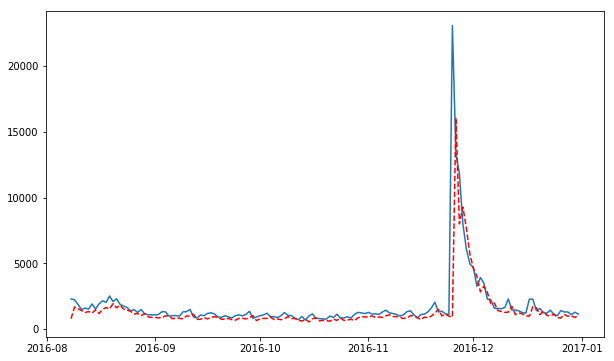

In [35]:
predictions = predict_with_no_updates(test, 4, model_fit)

ar_order = 4
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(test[ar_order:])
plt.plot(predictions, 'r', linestyle = '--')
plt.show()

In [36]:
mean_absolute_percentage_error(test[ar_order:], predictions)

59.961917032221926

In [37]:
def get_residuals(observed_series, predicted_series):
    # input are series of observed and predicted with the same index.
    # return the series of residuals
    observed = test[predicted_series.index].values
    predicted = predicted_series.values
    residuals = [observed[i]-predicted[i] for i in range(len(predictions))]
    residuals = pd.DataFrame(residuals)[0]
    residuals.index = predictions.index
    return residuals

In [38]:
residuals = get_residuals(test[predictions.index], predictions)

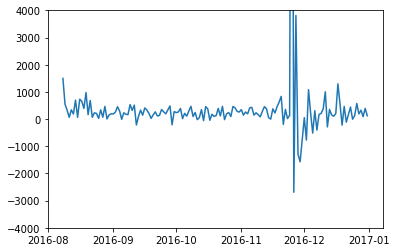

In [39]:
plt.plot(residuals)
plt.ylim((-4000, 4000))
plt.show()

In [40]:
# standardized residuals
from sklearn.preprocessing import StandardScaler
from math import sqrt

def standardize_pd_series(series):
    scaler = StandardScaler()
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    standardized = scaler.transform(values)
    standardized = pd.DataFrame(standardized, index=series.index)[0]
    return standardized

In [42]:
standardized_resid = standardize_pd_series(residuals)

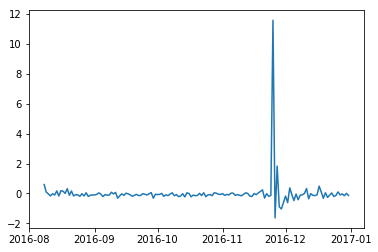

In [43]:
plt.plot(standardized_resid)
plt.show()

C:\Users\iacu9\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


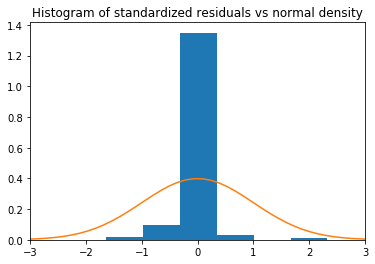

In [169]:
#histogram of rsiduals
import matplotlib.mlab as mlab

x = np.linspace(-3, max(standardized_resid), 100)

plt.xlim((-3,3)) #but un this way we can't see the outliers
plt.hist(standardized_resid, bins = 20, density=1)
plt.plot(x, mlab.normpdf(x, 0, 1))
plt.title('Histogram of standardized residuals vs normal density')
plt.show()

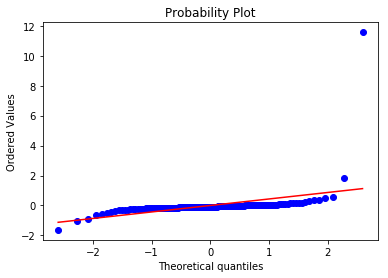

(0.43350266981490015, 4.2194818215011855e-17, 0.4271852536924163)


In [185]:
#import pylab 
import scipy.stats as stats

#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
r = stats.probplot(standardized_resid, dist=stats.norm, sparams=(0,1), plot=plt)
plt.show()

print(r[1]) #slope, intercept, r squared

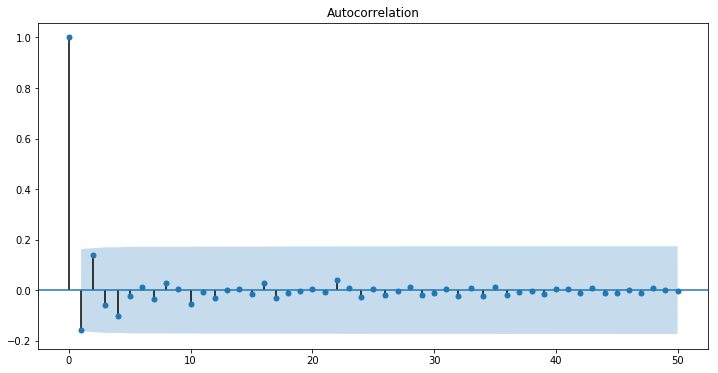

In [204]:
fig, ax = plt.subplots(figsize=(12,6))
ax = plot_acf(standardized_resid,ax = ax, lags = 50)

In [186]:
def predict_with_no_updates_mcmc(test_series, ar_order, trace):

    pre_sample = test_series
    predictions = list()
    for i in range(test.shape[0]-ar_order):
        values = pre_sample[:4]
        values = values[::-1]
        yhat = np.dot(get_coef_from_trace(trace), values)
        predictions.append(yhat)
        pre_sample = pre_sample[1:]

    predictions = pd.DataFrame(predictions)
    predictions.set_index(test[ar_order:].index, inplace=True, drop=True)
    return predictions

In [187]:
predictions_mcmc = predict_with_no_updates_mcmc(test, 4, trace)

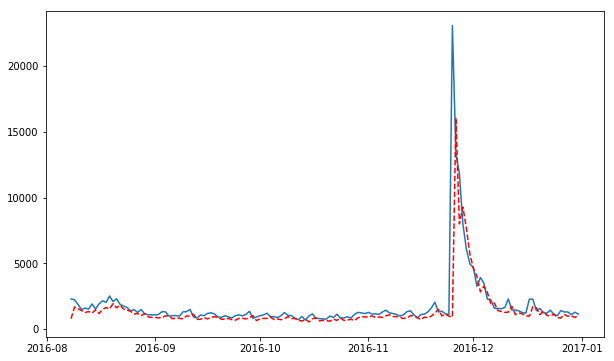

In [188]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(test[ar_order:])
plt.plot(predictions, 'r', linestyle = '--')
plt.show()

In [189]:
mean_absolute_percentage_error(test[ar_order:], predictions_mcmc)

60.000514734955516

In [190]:
residuals_mcmc = get_residuals(test[predictions_mcmc.index], predictions_mcmc)

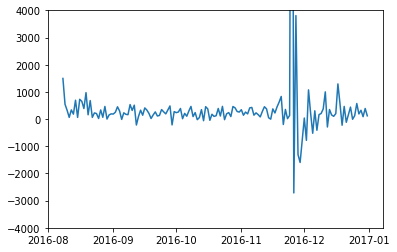

In [191]:
plt.plot(residuals_mcmc)
plt.ylim((-4000, 4000))
plt.show()

In [192]:
standardized_resid_mcmc = standardize_pd_series(residuals_mcmc)

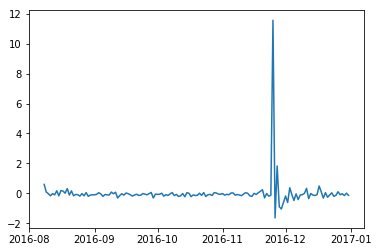

In [193]:
plt.plot(standardized_resid_mcmc)
plt.show()

C:\Users\iacu9\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


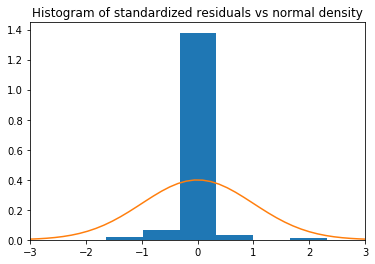

In [194]:
x = np.linspace(-3, max(standardized_resid_mcmc), 100)

plt.xlim((-3,3)) #but un this way we can't see the outliers
plt.hist(standardized_resid_mcmc, bins = 20, density=1)
plt.plot(x, mlab.normpdf(x, 0, 1))
plt.title('Histogram of standardized residuals vs normal density')
plt.show()

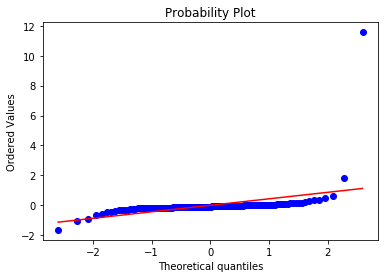

(0.43409281343164996, 6.658591495473266e-17, 0.4277667971711308)


In [195]:
#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
r = stats.probplot(standardized_resid_mcmc, dist=stats.norm, sparams=(0,1), plot=plt)
plt.show()

print(r[1]) #slope, intercept, r squared

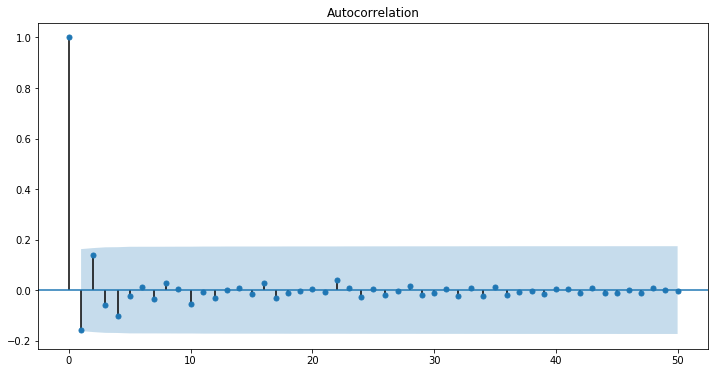

In [205]:
fig, ax = plt.subplots(figsize=(12,6))
ax = plot_acf(standardized_resid_mcmc,ax = ax, lags = 50)

In [91]:
# Dynamic models

# arima

def arima_model_pred_dynamic(X, ar_order):
    # prepare training dataset
    train_size = int(X.shape[0] * 0.66)
    train, test = X.iloc[0:train_size], X.iloc[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(test.shape[0]):
        model = ARIMA(history, order=(ar_order,0,0))
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        history = history[1:]
    # calculate out of sample error
    #error = mean_squared_error(test, predictions)
    predictions = pd.DataFrame(predictions)
    predictions.set_index(X[train_size:X.shape[0]].index, inplace=True, drop=True)
    return predictions[0]

In [86]:
def arima_model_pred_mc_dynamic(X, ar_order):
    # prepare training dataset
    train_size = int(X.shape[0] * 0.66)
    train, test = X.iloc[0:train_size], X.iloc[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(test.shape[0]):
        tau = 0.001

        model = pm.Model()
        with model:
    
            beta = pm.Uniform('beta',lower = -1, upper = 1,  shape = ar_order)
            y_obs = pm.AR('y_obs', rho = beta, tau=tau, observed=history)
            #trace = pm.sample(2000, tune=1000)
            step = pm.Metropolis()
    
            n_draws, n_chains = 3000, 3
            n_sim = n_draws*n_chains
    
            # Consider 3000 draws and 2 chains.
            trace = pm.sample(draws=n_draws, njobs=n_chains, step = step, tune = 1000)
            
        values =history[len(history)-ar_order:]
        values = values[::-1]
        yhat = np.dot(get_coef_from_trace(trace), values)
        predictions.append(yhat)
        history.append(test[t])
        history = history[1:]
    # calculate out of sample error
    #error = mean_squared_error(test, predictions)
    predictions = pd.DataFrame(predictions)
    predictions.set_index(X[train_size:X.shape[0]].index, inplace=True, drop=True)
    return predictions[0]

In [92]:
predictions = arima_model_pred_dynamic(most_frequent_series, 4)

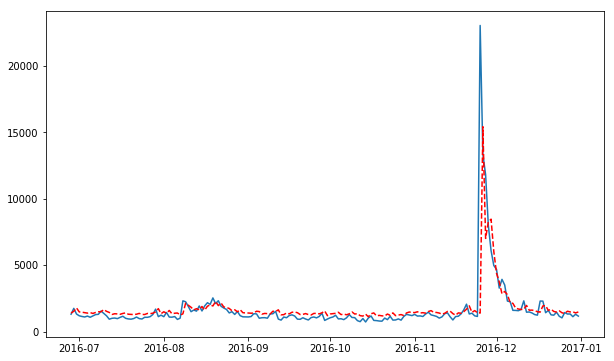

In [93]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(most_frequent_series[predictions.index])
plt.plot(predictions, 'r', linestyle = '--')
plt.show()

In [94]:
mean_absolute_percentage_error(most_frequent_series[predictions.index], predictions)

24.907400106009312

In [95]:
#predictions_mc = arima_model_pred_mc_dynamic(most_frequent_series, 4)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1739.34draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1741.32draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1727.53draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1732.02draws/s]
The estimated number of

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1663.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1663.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1676.91draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|██████████████████████

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1639.56draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1666.93draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1622.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiproces

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1559.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1581.86draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1569.43draws/s]
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [beta]
Sampling 3 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:07<00:00, 1537.53draws/s]
The number of effective samples i

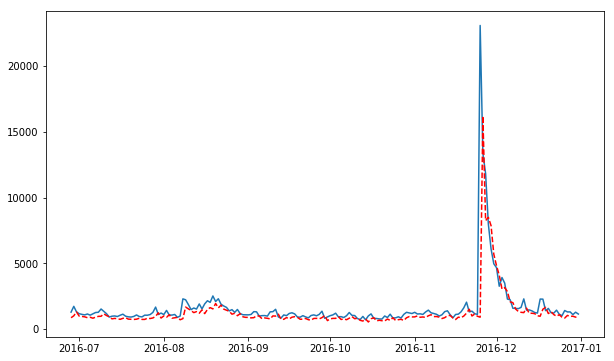

In [96]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(most_frequent_series[predictions_mc.index])
plt.plot(predictions_mc, 'r', linestyle = '--')
plt.show()

In [97]:
mean_absolute_percentage_error(most_frequent_series[predictions_mc.index], predictions_mc)

21.32417598397467

In [29]:
from statsmodels.tsa.arima_model import ARIMA
data = most_frequent_series[:400]

def auto_ar(series, max_order):
    best_score = float('inf')
    best_order = 0
    for i in range(0, max_order):
        model = ARIMA(series.values, order = (i,0,0))
        results_ARIMA = model.fit(disp=-1)
        aic = results_ARIMA.aic
        if aic < best_score:
            best_score = aic
            best_order = i
    print('the best ar order is ' + str(best_order))
    
 

In [31]:
auto_ar(data,10)

the best ar order is 1
